D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype 

22:24:08 Hora est. Pacífico, Sudamérica WARNING: Mode field at frequency index  
                                        0, mode index 1 does not decay at the   
                                        plane boundaries.                       

                                        WARNING: Mode field at frequency index  
                                        1, mode index 1 does not decay at the   
                                        plane boundaries.                       

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


22:24:09 Hora est. Pacífico, Sudamérica WARNING: Mode field at frequency index  
                                        0, mode index 1 does not decay at the   
                                        plane boundaries.                       

                                        WARNING: Mode field at frequency index  
                                        1, mode index 1 does not decay at the   
                                        plane boundaries.                       

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


22:24:10 Hora est. Pacífico, Sudamérica WARNING: Mode field at frequency index  
                                        0, mode index 1 does not decay at the   
                                        plane boundaries.                       

                                        WARNING: Mode field at frequency index  
                                        1, mode index 1 does not decay at the   
                                        plane boundaries.                       

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


                                        WARNING: Mode field at frequency index  
                                        0, mode index 1 does not decay at the   
                                        plane boundaries.                       

                                        WARNING: Mode field at frequency index  
                                        1, mode index 1 does not decay at the   
                                        plane boundaries.                       

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


22:24:11 Hora est. Pacífico, Sudamérica WARNING: Mode field at frequency index  
                                        1, mode index 1 does not decay at the   
                                        plane boundaries.                       

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


22:24:12 Hora est. Pacífico, Sudamérica WARNING: Mode field at frequency index  
                                        0, mode index 1 does not decay at the   
                                        plane boundaries.                       

                                        WARNING: Mode field at frequency index  
                                        1, mode index 1 does not decay at the   
                                        plane boundaries.                       

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype 

22:24:14 Hora est. Pacífico, Sudamérica WARNING: Mode field at frequency index  
                                        0, mode index 1 does not decay at the   
                                        plane boundaries.                       

                                        WARNING: Mode field at frequency index  
                                        1, mode index 1 does not decay at the   
                                        plane boundaries.                       

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype 

22:24:15 Hora est. Pacífico, Sudamérica WARNING: Mode '1' appears to undergo a  
                                        discontinuous change between frequencies
                                        '199861638666666.66' and                
                                        '187370286250000.0' (overlap: '0.01').  

                                        WARNING: Mode field at frequency index  
                                        1, mode index 1 does not decay at the   
                                        plane boundaries.                       

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype 

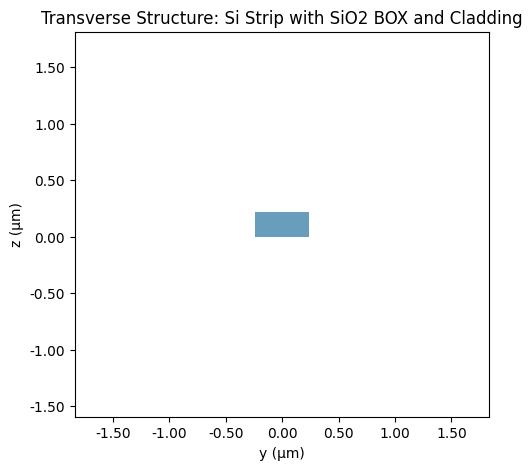

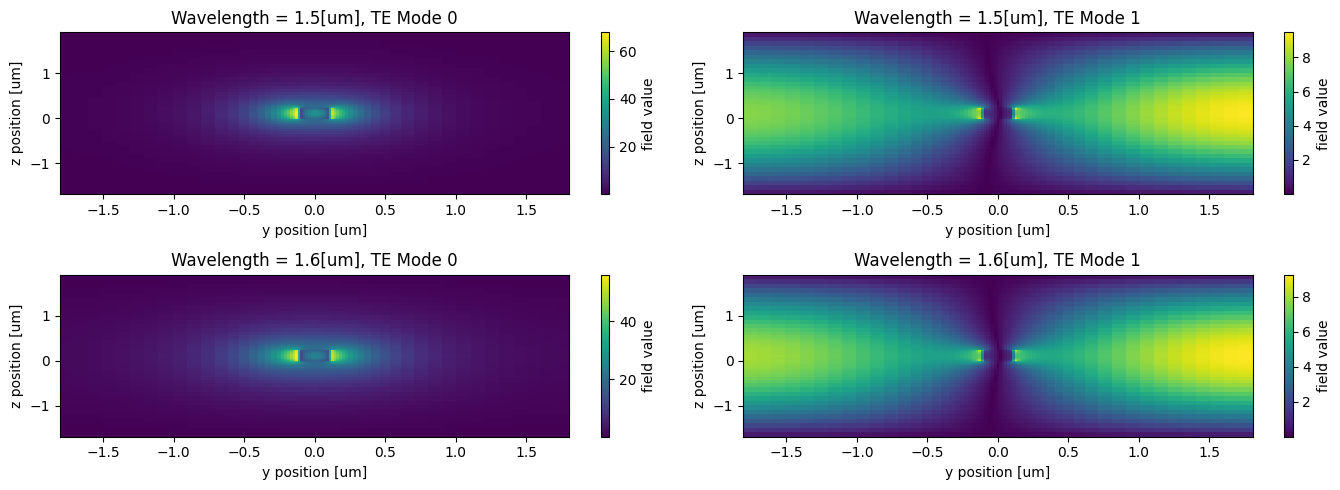

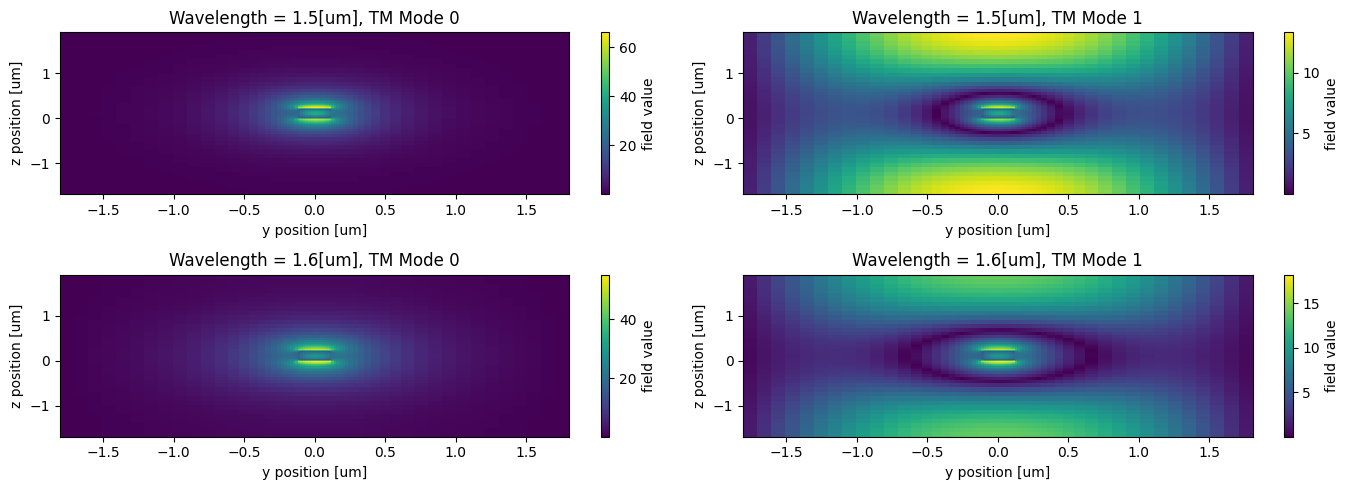

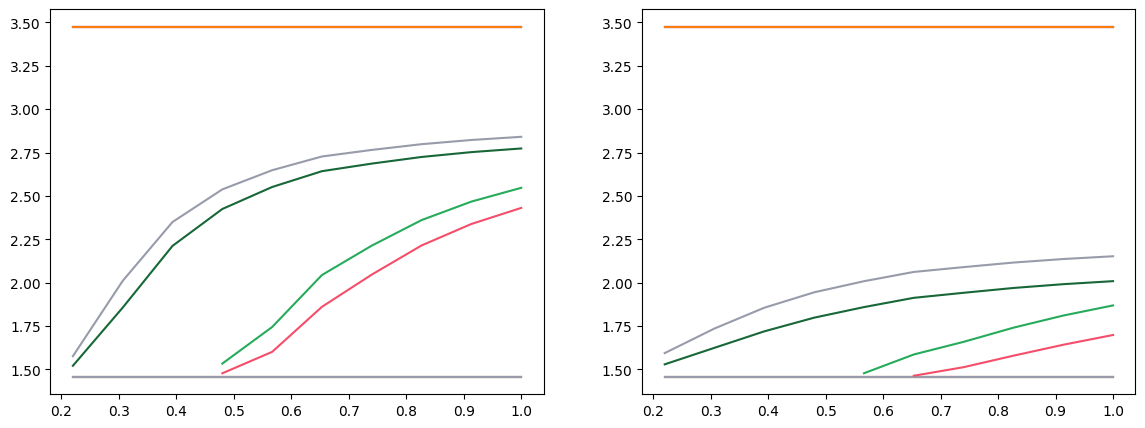

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
from tidy3d.plugins import waveguide
from tidy3d.plugins.mode import ModeSolver

# --- 1. Material Definitions ---
# Using fixed indices for 1550nm for simplicity

wavelength =  1.55                              # Central wavelength
wv_points = 2                                   # number of wavelength wv_points
wdth_points = 10                                # number of width wv_points
num_modes = 2                                   # max number of modes to look up
n_si = 3.475
n_sio2 = 1.458

sweep_wavelength = np.linspace(1.5,1.6,wv_points)  # Sweep on wavelengths
sweep_freq = td.C_0 / sweep_wavelength          # Sweep on Frequencies
sweep_width = np.linspace(0.220,1,wdth_points)

mat_si = td.material_library["cSi"]["Li1993_293K"] # Material trace permitivity model for crystaline Silicon
mat_sio2 = td.material_library["SiO2"]["Horiba"]   # Material trace permitivity model for crystaline Silica


def get_guided_modes(pol_type, width=0.48, thickness=0.22, wavelength = np.array([1.55])):
    """
    Separates TE/TM using Symmetry and counts only guided modes.
    """
    # For a waveguide centered vertically:
    # TE (Ey dominant): Z-Symmetry is Even (1)
    # TM (Ez dominant): Z-Symmetry is Odd (-1)
    # Note: We assume the waveguide is centered at z = thickness/2
    sym_z = 1 if pol_type == 'TE' else -1

    # We ask for the material properties from the wavelength we are on

    # eps_complex_si =mat_si.eps_model(td.C_0/wavelength)
    #
    # n_si = np.sqrt(eps_complex_si).real
    # k_si = np.sqrt(eps_complex_si).imag
    #
    # eps_complex_sio2 =mat_sio2.eps_model(td.C_0/wavelength)
    #
    # n_sio2 = np.sqrt(eps_complex_sio2).real
    # k_sio2 = np.sqrt(eps_complex_sio2).imag


    # Define the Plugin
    wg_plugin = waveguide.RectangularDielectric(
        wavelength=wavelength,
        core_width=width,
        core_thickness=thickness,
        core_medium=mat_si,
        clad_medium=mat_sio2,
        box_medium=mat_sio2,
        mode_spec=td.ModeSpec(num_modes=num_modes, target_neff=3.475) # Ask for many
    )

    # Correct way to get the simulation and apply symmetry
    # We access the simulation through the internal mode_solver
    sim_base = wg_plugin.mode_solver.simulation
    sym_sim = sim_base.copy(update={"symmetry": (0, 0, sym_z)})


    # Re-initialize the solver with the symmetric simulation
    solver = ModeSolver(
        simulation=sym_sim,
        plane=wg_plugin.mode_solver.plane,
        mode_spec=wg_plugin.mode_solver.mode_spec,
        freqs=wg_plugin.mode_solver.freqs
    )

    data = solver.solve()

    # Filter for guided modes only (n_eff > n_cladding)
    # squeeze() handles the frequency dimension
    n_eff_return = np.zeros((wv_points,num_modes))
    for freq_in in range(wv_points):
        n_effs = np.atleast_1d(data.n_eff.values.squeeze()[freq_in])
        guided_indices = np.where(n_effs > 1.458)[0]
        n_eff_return[freq_in][0:len(guided_indices)] = np.array(n_effs[guided_indices])

    return wg_plugin, n_eff_return, data



# --- 2. Execution ---


# Here we apply the defined function to obtain TE and TM modes separated and kept in te_neff as refractive effective index, and TE data kept on TE data
# Likewise with TM modes
strip_waveguide ,_, _ = get_guided_modes('TE')
te_neffs_arr,te_data_arr,tm_neffs_arr,tm_data_arr = (np.zeros((wdth_points,num_modes,wv_points)),
                                                     [],
                                                     np.zeros((wdth_points,num_modes,wv_points)),
                                                     [])

for wdth_idx,w in enumerate(sweep_width):
    _ ,te_neffs, te_data = get_guided_modes('TE', width = w, wavelength=sweep_wavelength)
    _,tm_neffs, tm_data = get_guided_modes('TM', width = w,  wavelength=sweep_wavelength)

    te_neffs_arr[wdth_idx,:,:] = te_neffs.T
    te_data_arr.append(te_data)
    tm_neffs_arr[wdth_idx,:,:] = tm_neffs.T
    tm_data_arr.append(tm_data)



# --- 3. Structure Visualization ---
# We plot the cross-section to verify materials and dimensions
# print(te_neffs_arr)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
strip_waveguide.plot_structures(x= 0, ax=ax)
plt.title("Transverse Structure: Si Strip with SiO2 BOX and Cladding")
plt.show()



# --- 5. Plotting Results for TE Light ---


# Mode index 0 is typically the fundamental Quasi-TE mode
fig1, axs = plt.subplots(len(te_neffs_arr[0]), wv_points, figsize=(14, 5))
# Plot Ey field (dominant component for TE in this orientation)
for freq_ind in range(wv_points):
    for modes in range(len(te_neffs_arr[0][freq_ind])):
        te_data_arr[0].Ey.abs.isel(f = freq_ind ,mode_index = modes).squeeze().plot(ax = axs[freq_ind][modes],x = 'y', y = 'z')
        axs[freq_ind][modes].set_title(f"Wavelength = {sweep_wavelength[freq_ind]}[um], TE Mode {modes}")


plt.tight_layout()
plt.show()



# --- 6. Plotting Results for TM Light ---


# Mode index 0 is typically the fundamental Quasi-TM mode
fig2, axs2 = plt.subplots(len(tm_neffs_arr[0]), wv_points, figsize=(14, 5))

# Plot Ey field (dominant component for TE in this orientation)
for freq_ind in range(wv_points):
    for modes in range(len(te_neffs_arr[0][freq_ind])):
        tm_data_arr[0].Ez.abs.isel(f = freq_ind ,mode_index = modes).squeeze().plot(ax = axs2[freq_ind][modes],x = 'y', y = 'z')
        axs2[freq_ind][modes].set_title(f"Wavelength = {sweep_wavelength[freq_ind]}[um], TM Mode {modes}")


plt.tight_layout()
plt.show()

# --- 7. Plotting results for width sweep---

fig3, ax_results = plt.subplots(1, 2, figsize=(14, 5))

def extract_nonzero_columns(padded_array):
    """
    Extracts the non-zero contiguous part of each column in a
    zero-padded 2D array.

    Parameters
    ----------
    padded_array : np.ndarray
        2D array where each column is zero-padded but contains
        a contiguous block of non-zero values.

    Returns
    -------
    list_of_arrays : list of np.ndarray
        List containing 1D arrays ready for plotting.
    """

    padded_array = np.asarray(padded_array)

    if padded_array.ndim != 2:
        raise ValueError("Input must be a 2D array.")

    extracted = []

    for col in padded_array.T:  # iterate over columns

        nonzero_indices = np.nonzero(col)[0]

        if len(nonzero_indices) == 0:
            extracted.append(np.array([]))
        else:
            start = nonzero_indices[0]
            end = nonzero_indices[-1] + 1
            extracted.append(col[start:end])

    return extracted

#Then we plot the results , y values n- effective and x values the widths


for wv_idx,wavelength in enumerate(sweep_wavelength):
    neff_cols_te = extract_nonzero_columns(te_neffs_arr[:,:,wv_idx])
    neff_cols_tm = extract_nonzero_columns(tm_neffs_arr[:,:,wv_idx])



    for (neff_ind, values_neff_te), (_, values_neff_tm) in zip(enumerate(neff_cols_te),enumerate(neff_cols_tm)):
        ax_results[0].plot(sweep_width,np.ones(wdth_points)*n_si)
        ax_results[0].plot(sweep_width,np.ones(wdth_points)*n_sio2)
        ax_results[0].plot(sweep_width[wdth_points-len(values_neff_te)::], values_neff_te)

        ax_results[1].plot(sweep_width,np.ones(wdth_points)*n_si)
        ax_results[1].plot(sweep_width,np.ones(wdth_points)*n_sio2)
        ax_results[1].plot(sweep_width[wdth_points-len(values_neff_tm)::], values_neff_tm)


# # --- 3. Results ---
# print(f"--- Results for Width {w_test}um ---")
# print(f"Found {len(te_neffs)} guided TE modes: {te_neffs}")
# print(f"Found {len(tm_neffs)} guided TM modes: {tm_neffs}")